# Overview
More or less a clone of `bold_register_scratch.ipynb` only now we are going to rely on manually alignment instead of the always failing ML models from ANTs. I don't mean to entirely imply that it is ANTs' fault, I might be misusing the models. However, it's proving difficult, and iterating over something that takes so long to align is taking forever. So lets go with the manual alignment.

**steps**
We will load all the data, run motion correction, and then manually align

# Setup and Load Data

In [6]:
from notebook_viewer_functions import *
from functions import *
from scivol import *
import numpy as np
import json
import ants
import gzip
import matplotlib.pyplot as plt
from ipywidgets import interact, Button, Output
import pickle
import napari
import matplotlib.transforms as mtransforms
import os
from PIL import Image

proj_root = parent_directory()
t1_input_filepath = os.path.join(proj_root, "media/sub-01/anat/sub-01_T1w.nii.gz")
bold_stim_filepath = os.path.join(proj_root, "media/sub-01/func/sub-01_task-emotionalfaces_run-1_bold.nii.gz")
bold_rest_filepath = os.path.join(proj_root, "media/sub-01/func/sub-01_task-rest_bold.nii.gz")
mni_anat_filepath =  os.path.join(proj_root, "templates/mni_icbm152_t1_tal_nlin_sym_09a.nii")
mni_mask_filepath = os.path.join(proj_root, "templates/mni_icbm152_t1_tal_nlin_sym_09a_mask.nii")
events_tsv_path = os.path.join(proj_root, "media/sub-01/func/task-emotionalfaces_run-1_events.tsv")
stimulus_image_path = "/Users/joachimpfefferkorn/repos/emotional-faces-psychopy-task-main/emofaces/POFA/fMRI_POFA"
log_path = "/Users/joachimpfefferkorn/repos/emotional-faces-psychopy-task-main/emofaces/data/01-subject_emofaces1_2019_Aug_14_1903.log"
cache_folder = "/Volumes/GlyphA_R1/nvol_cache"
template_folder =  os.path.join(proj_root, "templates/")
output_folder = os.path.join(proj_root, "output/")

raw_t1_img = ants.image_read(t1_input_filepath)
raw_stim_bold = ants.image_read(bold_stim_filepath)
raw_rest_bold_img = ants.image_read(bold_rest_filepath)
mni_template = ants.image_read(mni_anat_filepath)
mni_mask = ants.image_read(mni_mask_filepath)

In [7]:
bold_image = ants.image_read(bold_stim_filepath)
t1_image = ants.image_read(t1_input_filepath)

# Functions

In [8]:
def transform_BOLD(bold_frame: np.ndarray, translation: tuple, scale: tuple, rotation: tuple,):
    tx, ty, tz = translation
    sx, sy, sz = scale
    rx, ry, rz = rotation
    translation = np.array([
        [1, 0, 0, tx],
        [0, 1, 0, ty],
        [0, 0, 1, tz],
        [0, 0, 0, 1]
    ])

# Translation matrices copypasta from GPT
    scale = np.array([
            [sx, 0,  0,  0],
            [0,  sy, 0,  0],
            [0,  0,  sz, 0],
            [0,  0,  0,  1]
        ])

# I wonder where the origin is here...
    rotation_x = np.array([
        [1, 0, 0, 0],
        [0, np.cos(rx), -np.sin(rx), 0],
        [0, np.sin(rx), np.cos(rx), 0],
        [0, 0, 0, 1]
    ])
    rotation_y = np.array([
        [np.cos(ry), 0, np.sin(ry), 0],
        [0, 1, 0, 0],
        [-np.sin(ry), 0, np.cos(ry), 0],
        [0, 0, 0, 1]
    ])
    rotation_z = np.array([
        [np.cos(rz), -np.sin(rz), 0, 0],
        [np.sin(rz), np.cos(rz), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    rotation_matrix = rotation_x @ rotation_y @ rotation_z
    transformation_matrix = translation @ rotation @ scale

In [29]:
def normalize(arr):
    return np.array((arr - np.min(arr)) / (np.max(arr) - np.min(arr)))

def black_to_alpha_4D(arr):
    """
    Converts luma-based 4-D numpy array (such as a BOLD image)
    to an 0.0->1.0 RGBA array with all zero luma values read as alpha
    """
    # array will have arr.x arr.y and arr.z plus r g b a
    result = np.empty([arr.shape[0], arr.shape[1], arr.shape[2], arr.shape[3], 4], dtype=np.float32)

    result[:,:,:,:,0] = normalize(arr)
    result[:,:,:,:,1] = normalize(arr)
    result[:,:,:,:,2] = normalize(arr)

    result[:,:,:,:,3] = 0.0

    return result
    

In [30]:
normalized_bold = black_to_alpha_4D(registered_BOLD.numpy())

In [53]:
print("making test image")
test_image = registered_BOLD.numpy()[:,:,50,5]

pic = ba(test_image)
print(test_image.dtype)
print(pic)

print("displaying pic")
plt.imshow(pic)

making test image
float32


AttributeError: 'Image' object has no attribute 'dtype'

In [ ]:
def compare_bold_alignment(bold: np.ndarray, anat: np.ndarray):

    
    #dummy for now
    frame = 5
    slice = 100
    opacity = 0.5


    fig, axes = plt.subplots(1,3) #leaving figsize default for now
    #x
    #axes[0].imshow(anat[slice,:,:], cmap='gray')
    axes[0].imshow(ba(bold[slice,:,:, frame]), cmap='hot', alpha=opacity)
    #y
    axes[1].imshow(anat[:,slice,:], cmap='gray')
    axes[1].imshow(bold[:,slice,:, frame], cmap='hot', alpha=opacity)
    #z
    axes[2].imshow(anat[:,:,slice], cmap='gray')
    axes[2].imshow(ba(bold[:,:,slice, frame]), cmap='hot', alpha=opacity)
    
# def compare_bold_alignment(bold_seq_vol: np.ndarray, anat_vol: np.ndarray, dim='x'):
#     def x_coord(slice, frame, opacity):
#         fig, axes = plt.subplots(1,3, figsize=(15,5))

#         fig.suptitle('x axis view')

#         axes[0].imshow(bold_seq_vol[slice,:,:, frame], cmap='hot')
#         axes[0].set_title('BOLD')

#         axes[1].imshow(anat_vol[slice,:,:], cmap='gray')
#         axes[1].set_title('Anatomy')

#         axes[2].imshow(anat_vol[slice,:,:], cmap='gray')
#         axes[2].imshow(bold_seq_vol[slice,:,:, frame], cmap='hot', alpha=opacity)
#         axes[2].set_title('Overlay')

#     def y_coord(slice, frame, opacity):
#         fig, axes = plt.subplots(1,3, figsize=(15,5))

#         fig.suptitle('y axis view')

#         axes[0].imshow(bold_seq_vol[:,slice,:, frame], cmap='hot')
#         axes[0].set_title('BOLD')

#         axes[1].imshow(anat_vol[:,slice,:], cmap='gray')
#         axes[1].set_title('Anatomy')

#         axes[2].imshow(anat_vol[:,slice,:], cmap='gray')
#         axes[2].imshow(bold_seq_vol[:,slice,:, frame], cmap='hot', alpha=opacity)
#         axes[2].set_title('Overlay')

#     def z_coord(slice, frame, opacity):
#         fig, axes = plt.subplots(1,3, figsize=(15,5))

#         fig.suptitle('z axis view')

#         axes[0].imshow(bold_seq_vol[:,:,slice, frame], cmap='hot')
#         axes[0].set_title('BOLD')

#         axes[1].imshow(anat_vol[:,:,slice], cmap='gray')
#         axes[1].set_title('Anatomy')

#         axes[2].imshow(anat_vol[:,:,slice], cmap='gray')
#         axes[2].imshow(bold_seq_vol[:,:,slice, frame], cmap='hot', alpha=opacity)
#         axes[2].set_title('Overlay')

#     match dim:
#         case "x":
#             interact(x_coord, slice=(0, anat_vol.shape[0]-1), frame=(0, bold_seq_vol.shape[3]-1),opacity=(0, 1.0))
#         case 'y':
#             interact(y_coord, slice=(0, anat_vol.shape[1]-1), frame=(0, bold_seq_vol.shape[3]-1),opacity=(0, 1.0))
#         case 'z':
#             interact(z_coord, slice=(0, anat_vol.shape[2]-1), frame=(0, bold_seq_vol.shape[3]-1),opacity=(0, 1.0))


In [9]:
def generate_brain_mask(anat, mni_template, mni_mask):
    #Don't love the term "anat" as this should work with BOLD, but what is it if not anatomy?
    template_warp_to_raw_anat = ants.registration(
    fixed=anat,
    moving=mni_template, 
    type_of_transform='SyN',
    verbose=False
    )
    print("Creating brain mask")
    brain_mask = ants.apply_transforms(
        fixed=template_warp_to_raw_anat['warpedmovout'],
        moving=mni_mask,
        transformlist=template_warp_to_raw_anat['fwdtransforms'],
        interpolator='nearestNeighbor',
        verbose=False
    )
    return brain_mask

In [10]:
def skull_strip_anat(anat, mni_template, mni_mask, dilate=True):
    """
    anat, mni_template, mni_mask must all be ANTS images.
    """
    print("Skull Stripping Anatomy Volume")
    print("Registering template to frame")
    brain_mask = generate_brain_mask(anat, mni_template, mni_mask)
    if dilate:
        print("Dilating brain mask")
        brain_mask = ants.morphology(brain_mask, radius=4, operation='dilate', mtype='binary')
    print("Masking brain")
    isolated_brain = ants.mask_image(anat, brain_mask)
    print("Done")
    return isolated_brain

In [11]:
def skull_strip_bold(bold, mni_template, mni_mask, dilate=False):
    """
    Assuming a motion corrected or relatively BOLD image
    """
    
    print("Skull strip for BOLD")
    isolated_brain_vol_frames = []
    for frame in range(bold.shape[3]):
        print(f"Skull stripping bold frame {frame + 1}/{bold.shape[3]}")
        bold_frame = ants.from_numpy(bold.numpy()[:,:,:,frame],
                                    spacing=bold.spacing[:3])
        brain_mask = generate_brain_mask(bold_frame, mni_template, mni_mask)
        if dilate:
            print("Dilating brain mask")
            brain_mask = ants.morphology(brain_mask, radius=4, operation='dilate', mtype='binary')
        isolated_brain_vol = ants.mask_image(bold_frame, brain_mask).numpy()
        isolated_brain_vol_frames.append(isolated_brain_vol)
    print("Creating new ANTsImage from isolated brain volumes")
    data = np.stack([frame for frame in isolated_brain_vol_frames], axis=3)
    isolated_brain_bold_img = ants.from_numpy(data, origin=bold.origin, spacing=bold.spacing)
    print("Done")
    return isolated_brain_bold_img
    
        

In [12]:
def align_stabilized_bold_to_anat(bold_img, t1_img, template_frame_idx=0):
    """"
    """

    print("Aligning stabilized bold to anat\nEstablishing temporal mean")
    template_frame_idx = ants.from_numpy(bold_img.numpy()[:,:,:,template_frame_idx], spacing=bold_img.spacing[:3])

    frame_registration = ants.registration(
        fixed=t1_img,
        moving=template_frame_idx,
        type_of_transform="Rigid", 
    )
    registered_frames = []

    print("Applying transformations to frames")
    for frame in range(bold_img.shape[3]):
        print(f"frame{frame}/{bold_img.shape[3]}")
        print("creating image of bold frame")
        bold_frame = ants.from_numpy(bold_img.numpy()[:,:,:,frame],
                                     spacing=bold_img.spacing[:3])
        print("     Applying frame transformation")
        registered_frame = ants.apply_transforms(
            fixed=t1_img,
            moving=bold_frame,
            transformlist=frame_registration['fwdtransforms'],
            interpolator='linear'
        )
        print("     adding registered frame to list")
        registered_frames.append(registered_frame.numpy())
    print("Creating 4D numpy vol from list of 3D ANTs imgs")
    data = np.stack([frame for frame in registered_frames], axis=3)
    print("Creating 4D bold image from numpy vol")
    registered_bold_img = ants.from_numpy(data, origin=bold_img.origin, spacing=bold_img.spacing)
    return registered_bold_img

# Skull Stripping

In [13]:
isolated_t1 = skull_strip_anat(t1_image, mni_template, mni_mask)

Skull Stripping Anatomy Volume
Registering template to frame
Creating brain mask
Dilating brain mask
Masking brain
Done


In [14]:
# Truncated Version
sliced = bold_image.numpy()[:, :, :, :10]
bold_truncated_img = ants.from_numpy(sliced, spacing=bold_image.spacing, origin=bold_image.origin, direction=bold_image.direction)
#stabilized = ants.motion_correction(bold_image)
stabilized_truncated = ants.motion_correction(bold_truncated_img)
isolated_bold = skull_strip_bold(stabilized_truncated['motion_corrected'], mni_template, mni_mask)

Skull strip for BOLD
Skull stripping bold frame 1/10
Creating brain mask
Skull stripping bold frame 2/10
Creating brain mask
Skull stripping bold frame 3/10
Creating brain mask
Skull stripping bold frame 4/10
Creating brain mask
Skull stripping bold frame 5/10
Creating brain mask
Skull stripping bold frame 6/10
Creating brain mask
Skull stripping bold frame 7/10
Creating brain mask
Skull stripping bold frame 8/10
Creating brain mask
Skull stripping bold frame 9/10
Creating brain mask
Skull stripping bold frame 10/10
Creating brain mask
Creating new ANTsImage from isolated brain volumes
Done


In [15]:
#Quick check in napari

# viewer = napari.Viewer()
# viewer.add_image(np.transpose(isolated_bold.numpy(), axes=(3,0,1,2)), name="BOLD")
# viewer.add_image(t1_image.numpy(), name="T1 full anat")
# viewer.add_image(isolated_t1.numpy(), name="T1 Brain")

# The Meat of it All

Alignment hasn't been working without skull stripping, so let's reintroduce that


Of note, `AntsPyNet` has a built in function that might be a bit more robust. However, it is heavy and falls into dependency hell quite quickly. It would be worth playing around with, but the heaviness of the package might be antithetical to Neurovolume

In [20]:
registered_BOLD = align_stabilized_bold_to_anat(stabilized_truncated['motion_corrected'], t1_image)

Aligning stabilized bold to anat
Establishing temporal mean
Applying transformations to frames
frame0/10
creating image of bold frame
     Applying frame transformation
     adding registered frame to list
frame1/10
creating image of bold frame
     Applying frame transformation
     adding registered frame to list
frame2/10
creating image of bold frame
     Applying frame transformation
     adding registered frame to list
frame3/10
creating image of bold frame
     Applying frame transformation
     adding registered frame to list
frame4/10
creating image of bold frame
     Applying frame transformation
     adding registered frame to list
frame5/10
creating image of bold frame
     Applying frame transformation
     adding registered frame to list
frame6/10
creating image of bold frame
     Applying frame transformation
     adding registered frame to list
frame7/10
creating image of bold frame
     Applying frame transformation
     adding registered frame to list
frame8/10
creatin

In [19]:
print(registered_BOLD)

NameError: name 'registered_BOLD' is not defined

In [22]:
# viewer.add_image(isolated_t1.numpy(), name="t1")
# viewer.add_image(np.transpose(registered_BOLD.numpy(), axes=(3,0,1,2)), name="Bold")

In [21]:
print(registered_BOLD)
print(t1_image)

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 512, 296, 10)
	 Spacing    : (4.0, 4.0, 4.0, 2.0)
	 Origin     : (-127.953, 108.933, -74.8393, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 512, 296)
	 Spacing    : (0.4785, 0.4785, 0.5)
	 Origin     : (119.989, 104.52, -84.2457)
	 Direction  : [-1.      0.0025  0.     -0.0025 -1.      0.      0.      0.      1.    ]



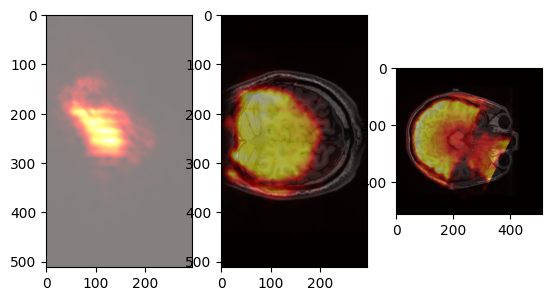

In [24]:
compare_bold_alignment(registered_BOLD.numpy(), t1_image.numpy())
